In [119]:
import numpy as np
import scipy.special
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import ndcube
from ndcube.extra_coords import QuantityTableCoordinate
from sunpy.coordinates import get_earth, Helioprojective
from astropy.convolution import convolve, Gaussian1DKernel

import fiasco
from mocksipipeline.physics.spectral import get_spectral_tables
from mocksipipeline.detector.response import SpectrogramChannel, convolve_with_response, ThinFilmFilter
from synthesizAR.instruments import InstrumentDEM
from overlappy.wcs import overlappogram_fits_wcs, pcij_matrix

In [120]:
def degrade_spectra(spec, resolution, chan):
    std = resolution / (2*np.sqrt(2*np.log(2)))  # FWHM is 0.5 so convert to sigma using W = 2\sqrt{2\ln2}\sigma
    std_eff = (std / chan.spectral_resolution).to_value('pix')  # Scale sigma by bin width
    kernel = Gaussian1DKernel(std_eff)
    data_smooth = convolve(spec.data, kernel)
    return ndcube.NDCube(data_smooth, wcs=spec.wcs, meta=spec.meta, unit=spec.unit)

In [92]:
def compute_total_flux(dem, spec_table, chan_1, chan_3, x_1, x_3):
    intensity = InstrumentDEM.calculate_intensity(dem, spec_table, {})
    flux_1 = convolve_with_response(intensity, chan_1, electrons=False, include_gain=False)
    flux_3 = convolve_with_response(intensity, chan_3, electrons=False, include_gain=False)
    flux_total = ndcube.NDCube(flux_1.data+np.interp(x_1, x_3, flux_3.data),
                               wcs=flux_1.wcs, unit=flux_1.unit)
    return flux_total

In [2]:
def get_abundance(element, abundance_filename):
    el = fiasco.Element(element, 1*u.MK, abundance_filename=abundance_filename)
    return el.abundance

In [182]:
def add_line_ids_to_axis(ax, line_ids, rotation=90, use_wcs=True, axis_unit=None, add_ticklabels=True, wcs=None, color='k'):
    if use_wcs:
        if wcs is None:
            ax_wcs = ax.wcs
        else:
            ax_wcs = wcs
    for ion,line in line_ids:
        if use_wcs:
            x_loc = ax_wcs.world_to_pixel(line)
        else:
            x_loc = line.to_value(axis_unit)
        ax.axvline(x=x_loc, ls=':', color=color,)
    if add_ticklabels:
        ax2 = ax.secondary_xaxis('top')
        x_tick_locs = u.Quantity([l for _,l in line_ids])
        if use_wcs:
            x_tick_locs = ax_wcs.world_to_pixel(x_tick_locs)
        else:
            x_tick_locs = x_tick_locs.to_value(axis_unit)
        ax2.set_xticks(x_tick_locs,
                       labels=[f'{ion}, {line.to_string(format="latex_inline")}' for ion,line in line_ids],
                       rotation=rotation,
                       horizontalalignment='center',
                       color=color,
                       #verticalalignment='center'
                      )

In [4]:
def get_line_ratio(spectra, wavelengths, line_num, line_denom):
    i_num = np.argmin(np.fabs(wavelengths - line_num))
    i_denom = np.argmin(np.fabs(wavelengths - line_denom))
    ratio = spectra[i_num] / spectra[i_denom]
    return ratio

In [5]:
def dem_table_to_ndcube(dem, temperature, meta=None):
    tab_coord = QuantityTableCoordinate(temperature,
                                        names='temperature',
                                        physical_types='phys.temperature')
    return ndcube.NDCube(dem, wcs=tab_coord.wcs, meta=meta)

In [6]:
def get_goft(ion, wave, p0=1e15*u.K*u.cm**(-3)):
    density = p0 / ion.temperature
    g_of_t = ion.contribution_function(density, couple_density_to_temperature=True)
    transitions = ion.transitions.wavelength[~ion.transitions.is_twophoton]
    idx = np.argmin(np.abs(transitions - wave))
    return g_of_t[..., idx]

In [7]:
line_ids = [
    ('Fe XVIII',14.21*u.angstrom),  # also targeted by MaGIXS
    ('Fe XVII', 15.01*u.angstrom),  # also targeted by MaGIXS
    ('Fe XVII', 16.78*u.AA),
    ('Fe XVII', 17.05*u.AA),
    ('O VII', 21.60*u.angstrom),  # also targeted by MaGIXS
    ('O VII', 21.81*u.angstrom),
    ('O VII', 22.10*u.AA),
    ('O VIII', 18.97*u.angstrom),  # also targeted by MaGIXS
    ('Fe XXV', 1.86*u.AA),
    ('Ca XIX', 3.21*u.AA),
    ('Si XIII', 6.74*u.AA),
    ('Mg XI', 9.32*u.AA),
    ('Fe XVII', 11.25*u.AA),
    ('Fe XX', 12.83*u.AA),
    ('Ne IX', 13.45*u.AA),
    ('Fe XIX', 13.53*u.AA),
    ('C VI', 33.73*u.AA),
    ('C V', 40.27*u.AA),
    ('Si XII', 44.16*u.AA),
    ('Si XI', 49.18*u.AA),
]

# Observables from Analytical DEMs

In this notebook:

1. Generate analytical DEMs following Guennou et al. (2012) parameterized over $(T_p,a,b)$
2. For each DEM compute MOXSI spectra using response functions and CHIANTI data
3. Look at select intensity ratios
4. Analyze how the diagnostic power of these observables vary as the effective spectral resolution $\Delta\lambda_{Eff}$ decreases.

Grab DEM data from CHIANTI

In [8]:
dem_cubes = []
for fname in ['flare.dem', 'active_region.dem', 'quiet_sun.dem']:
    p = fiasco.io.Parser(fname, ascii_dbase_root='/Users/wtbarnes/ssw/packages/chianti/dbase/')
    tab = p.parse()
    dem_cubes.append((fname, dem_table_to_ndcube(tab['em'], tab['temperature_bin_center'], meta=tab.meta)))
dem_models = ndcube.NDCollection(dem_cubes)

## Analytical DEM

In [9]:
def guennou_dem(temperature, T_P, EM_total, alpha, sigma, sigma_fw=0.15):
    T_P = T_P.to(temperature.unit)
    T_0 = calculate_tangent_point(T_P, alpha, sigma_fw)
    norm_factor = EM_total  #/ _normalization_integral(T_0, T_P, alpha, sigma, sigma_fw)
    dem_low = guennou_dem_low(temperature, T_0, T_P, alpha, sigma_fw)
    dem_high = guennou_dem_high(temperature, T_P, sigma, sigma_fw)
    dem = guennou_dem_connection(temperature, T_P, sigma_fw)
    dem[temperature < T_0] = dem_low[temperature < T_0]
    dem[temperature > T_P] = dem_high[temperature > T_P]
    dem = dem * norm_factor
    return dem


def calculate_tangent_point(T_P, alpha, sigma):
    # Point of tangency between Gaussian and power-law 
    # in log-log space
    return T_P * 10**(-alpha * (sigma**2) * np.log(10))


def _gaussian(x, sigma):
    return np.exp(-((x/sigma)**2)/2)/sigma/np.sqrt(2*np.pi)


def _normalization_integral(T_0, T_P, alpha, sigma, sigma_fw):
    x = np.log10(T_0.to_value('K')) - np.log10(T_P.to_value('K'))
    term_1 = _gaussian(x, sigma_fw) / alpha
    term_2 = sigma / np.sqrt(2)
    term_3 = sigma_fw / np.sqrt(2) * scipy.special.erf(-x / (2 * sigma_fw**2))
    return term_1 + term_2 + term_3


def guennou_dem_low(temperature, T_0, T_P, alpha, sigma):
    x = np.log10(T_0.to_value('K')) - np.log10(T_P.to_value('K'))
    return _gaussian(x, sigma) * (temperature / T_0)**alpha


def guennou_dem_high(temperature, T_P, sigma, sigma_fw):
    x = np.log10(temperature.to_value('K')) - np.log10(T_P.to_value('K'))
    return _gaussian(x, sigma) * sigma / sigma_fw
    
    
def guennou_dem_connection(temperature, T_P, sigma):
    x = np.log10(temperature.to_value('K')) - np.log10(T_P.to_value('K'))
    return _gaussian(x, sigma)

In [72]:
temperature = 10**np.arange(5,8,0.01) * u.K
EM_total = 1e28 * u.cm**(-5)
T_P = 4e6 * u.K
alpha = 2
sigma = 0.05
sigma_fw = 0.15
T_0 = calculate_tangent_point(T_P, alpha, sigma_fw)

(10000.0, 100000000.0)

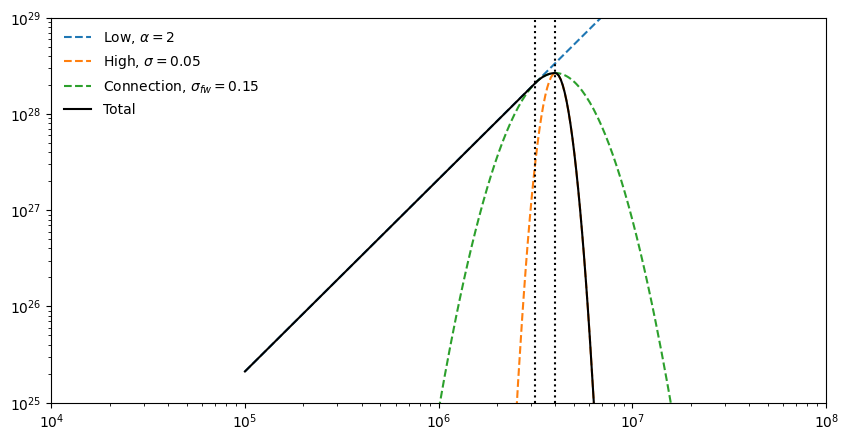

In [73]:
plt.figure(figsize=(10,5))
plt.plot(temperature, EM_total*guennou_dem_low(temperature, T_0, T_P, alpha, sigma_fw), label=f'Low, $\\alpha={alpha}$', ls='--')
plt.plot(temperature, EM_total*guennou_dem_high(temperature, T_P, sigma, sigma_fw), label=f'High, $\\sigma={sigma}$', ls='--')
plt.plot(temperature, EM_total*guennou_dem_connection(temperature, T_P, sigma_fw), label=f'Connection, $\\sigma_{{fw}}={sigma_fw}$', ls='--')
plt.plot(temperature, guennou_dem(temperature, T_P, EM_total, alpha, sigma, sigma_fw=sigma_fw), ls='-', color='k', label='Total')
plt.xscale('log')
plt.yscale('log')
#plt.ylim(EM_total.to_value('cm-5')*np.array([1e-5, 100]))
plt.ylim(1e25, 1e29)
plt.axvline(x=T_0.to_value('K'), ls=':', color='k')
plt.axvline(x=T_P.to_value('K'), ls=':', color='k')
plt.legend(loc=2, frameon=False)
plt.xlim(1e4, 1e8)

Approximately reproduce the Guennou et al. (2012) Figure 1

(10000.0, 100000000.0)

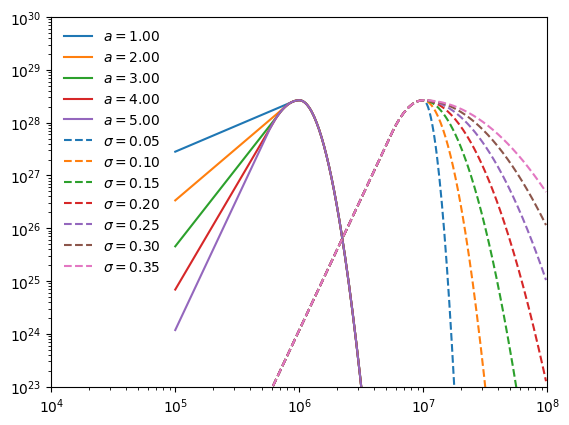

In [61]:
for i,a in enumerate(np.arange(1,6,1)):
    plt.plot(temperature, guennou_dem(temperature, 1*u.MK, EM_total, a, 0.1),
             label=f'$a={a:.2f}$', ls='-', color=f'C{i}')
for i,sig in enumerate(np.arange(0.05,0.4,0.05)):
    plt.plot(temperature, guennou_dem(temperature, 10*u.MK, EM_total, 5, sig),
             ls='--', label=f'$\sigma={sig:.2f}$', color=f'C{i}')
plt.xscale('log')
plt.yscale('log')
plt.ylim(EM_total.to_value('cm-5')*np.array([1e-5, 100]))
#plt.ylim(1e23, 1e28)
plt.legend(loc=2, frameon=False)
plt.xlim(1e4, 1e8)

For a given set of parameters, the analytical DEM can match those from CHIANTI fairly well. This is just to prove these are reasonable parameterizations of the curve.

(1e+24, 1e+28)

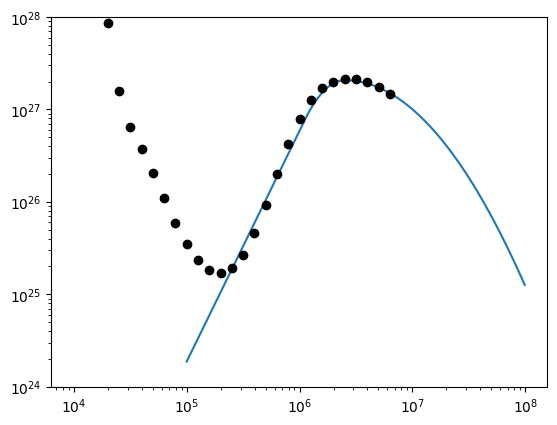

In [51]:
plt.plot(temperature, guennou_dem(temperature, 2.5e6*u.K, 1.3e27*u.cm**(-5), 2.5, 0.5, sigma_fw=0.25))
plt.plot(dem_models['active_region.dem'].axis_world_coords(0)[0],
         dem_models['active_region.dem'].data, 'ok')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e24, 1e28)

(1000000.0, 100000000.0)

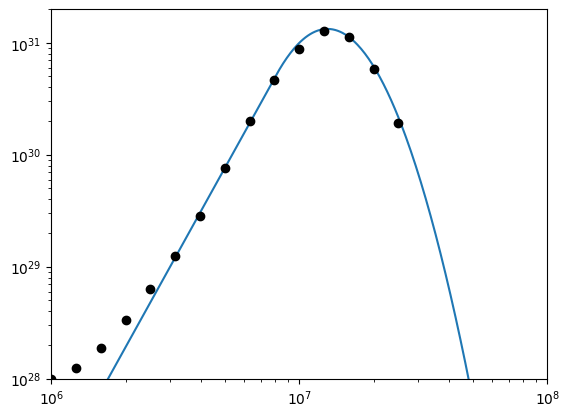

In [52]:
plt.plot(temperature, guennou_dem(temperature, 1.3e7*u.K, 5e30*u.cm**(-5), 4, 0.15, sigma_fw=0.15))
plt.plot(dem_models['flare.dem'].axis_world_coords(0)[0],
         dem_models['flare.dem'].data, 'ok')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e28, 2e31)
plt.xlim(1e6,1e8)

## Computing Spectra

Now, I want to compute spectra while varying $\sigma$ and $\alpha$ to better understand how even modest amounts of hot plasma in an AR might change our resulting spectra

In [75]:
al_filter = ThinFilmFilter(elements='Al', thickness=150*u.nm, xrt_table='Chantler')
chan_1 = SpectrogramChannel(1, al_filter)
chan_3 = SpectrogramChannel(3, al_filter)

In [91]:
earth_observer = get_earth(time='2020-01-01 12:00:00')
flare_loc = SkyCoord(Tx=-900*u.arcsec, Ty=0*u.arcsec,
                     frame=Helioprojective(obstime=earth_observer.obstime, observer=earth_observer))
roll_angle = -90 * u.deg
dispersion_angle = 0*u.deg
wcs_1 = overlappogram_fits_wcs(
    chan_1.detector_shape,
    chan_1.wavelength,
    (chan_1.resolution[0], chan_1.resolution[1], chan_1.spectral_resolution),
    reference_pixel=chan_1.reference_pixel,
    reference_coord=(0*u.arcsec, 0*u.arcsec, 0*u.angstrom),
    pc_matrix=pcij_matrix(roll_angle, dispersion_angle, order=chan_1.spectral_order,),
    observer=earth_observer,
)
wcs_3 = overlappogram_fits_wcs(
    chan_3.detector_shape,
    chan_3.wavelength,
    (chan_3.resolution[0], chan_3.resolution[1], chan_3.spectral_resolution),
    reference_pixel=chan_3.reference_pixel,
    reference_coord=(0*u.arcsec, 0*u.arcsec, 0*u.angstrom),
    pc_matrix=pcij_matrix(roll_angle, dispersion_angle, order=chan_3.spectral_order,),
    observer=earth_observer,
)
pix_x_1, _, _ = wcs_1.world_to_pixel(flare_loc, chan_1.wavelength)
pix_x_3, _, _ = wcs_3.world_to_pixel(flare_loc, chan_3.wavelength)

In [54]:
spec_tables = get_spectral_tables()

First, fix the amount of cool plasma and vary the relative amount of hot plasma. In all cases, I'm pinning the peak emission measure and the temperature at which it peaks to 4 MK.

In [117]:
blur = 0.5 * u.angstrom

/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/ipykernel_60442/2864038658.py:32: RuntimeWarning: invalid value encountered in divide
  ax3.plot(pix_x_1, flux.data/flux0.data, ls='-')


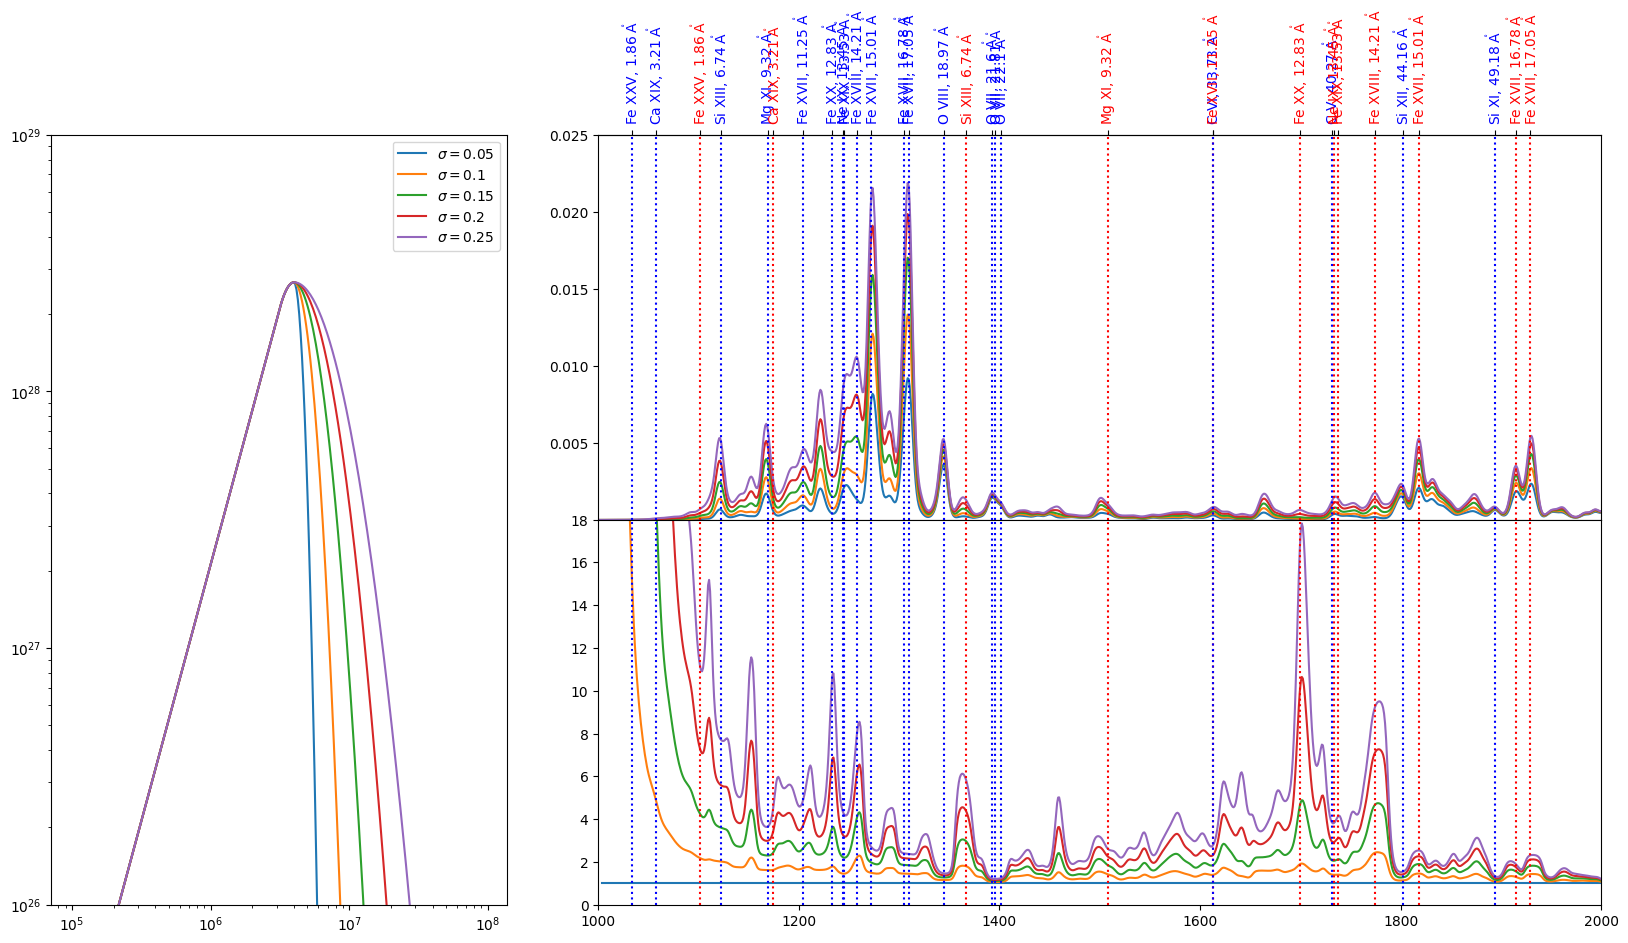

In [263]:
fig = plt.figure(figsize=(20,10))
gs = GridSpec(2, 3,)
ax1 = fig.add_subplot(gs[:,0])
ax2 = fig.add_subplot(gs[0,1:])
ax3 = fig.add_subplot(gs[1,1:])
#ax3 = ax2.twinx()
sigmas = [0.05, 0.1, 0.15, 0.2, 0.25]
#spec_table = get_abundance('ca','sun_coronal_1992_feldman_ext')*spec_tables['unity_ca']
spec_table = spec_tables['sun_coronal_1992_feldman_ext_all']
flux0 = compute_total_flux(
    dem_table_to_ndcube(guennou_dem(temperature, 4*u.MK, EM_total, 2, sigmas[0]), temperature),
    spec_table,
    chan_1,
    chan_3,
    pix_x_1,
    pix_x_3
)
flux0 = degrade_spectra(flux0, blur, chan_1)
for sig in sigmas:
    dem = guennou_dem(temperature, 4*u.MK, EM_total, 2, sig)
    ax1.plot(temperature, dem, label=f'$\sigma={sig}$')
    flux = compute_total_flux(
        dem_table_to_ndcube(dem, temperature),
        spec_table,
        chan_1,
        chan_3,
        pix_x_1,
        pix_x_3
    )
    flux = degrade_spectra(flux, blur, chan_1)
    ax2.plot(pix_x_1, flux.data, label=f'$\sigma={sig}$')
    ax3.plot(pix_x_1, flux.data/flux0.data, ls='-')
# Add vertical lines denoting lines
order_1_color = 'blue'
order_3_color = 'red'
for ion,line in line_ids:
    x_pos,_,_ = wcs_1.world_to_pixel(flare_loc, line)
    ax2.axvline(x=x_pos, ls=':', color=order_1_color,)
    ax3.axvline(x=x_pos, ls=':', color=order_1_color,)
    x_pos,_,_ = wcs_3.world_to_pixel(flare_loc, line)
    ax2.axvline(x=x_pos, ls=':', color=order_3_color,)
    ax3.axvline(x=x_pos, ls=':', color=order_3_color,)
# Add tick labels for lines
tick_locs_1 = wcs_1.world_to_pixel(flare_loc, u.Quantity([l for _,l in line_ids]))[0]
tick_locs_3 = wcs_3.world_to_pixel(flare_loc, u.Quantity([l for _,l in line_ids]))[0]
tick_labels = [f'{ion}, {line.to_string(format="latex_inline")}' for ion,line in line_ids]
ax_top = ax2.secondary_xaxis('top') 
ax_top.set_xticks(np.hstack([tick_locs_1, tick_locs_3]),
                  labels=tick_labels+tick_labels,
                  rotation=90,
                  horizontalalignment='center',
                  color=order_1_color);
for i,tick in enumerate(ax_top.get_xticklabels()):
    if i>=len(tick_labels):
        tick.set_color(order_3_color)
# Limits and scale
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim(1e26, 1e29)
ax1.legend()
#ax2.set_yscale('log')
ax2.set_ylim(2e-5, 2.5e-2)
ax2.set_xlim(1000,2000)
ax3.set_ylim(0,18)
#ax3.set_yscale('log')
ax3.set_xlim(ax2.get_xlim())
# Spacing and tick pruning
ax2.set_xticks([])
plt.subplots_adjust(hspace=0)

In [254]:
ax2.get_xlim()

(1000.0, 2000.0)

/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/ipykernel_60442/3889499626.py:28: RuntimeWarning: invalid value encountered in divide
  ax3.plot(pix_x_1, flux.data/flux0.data)


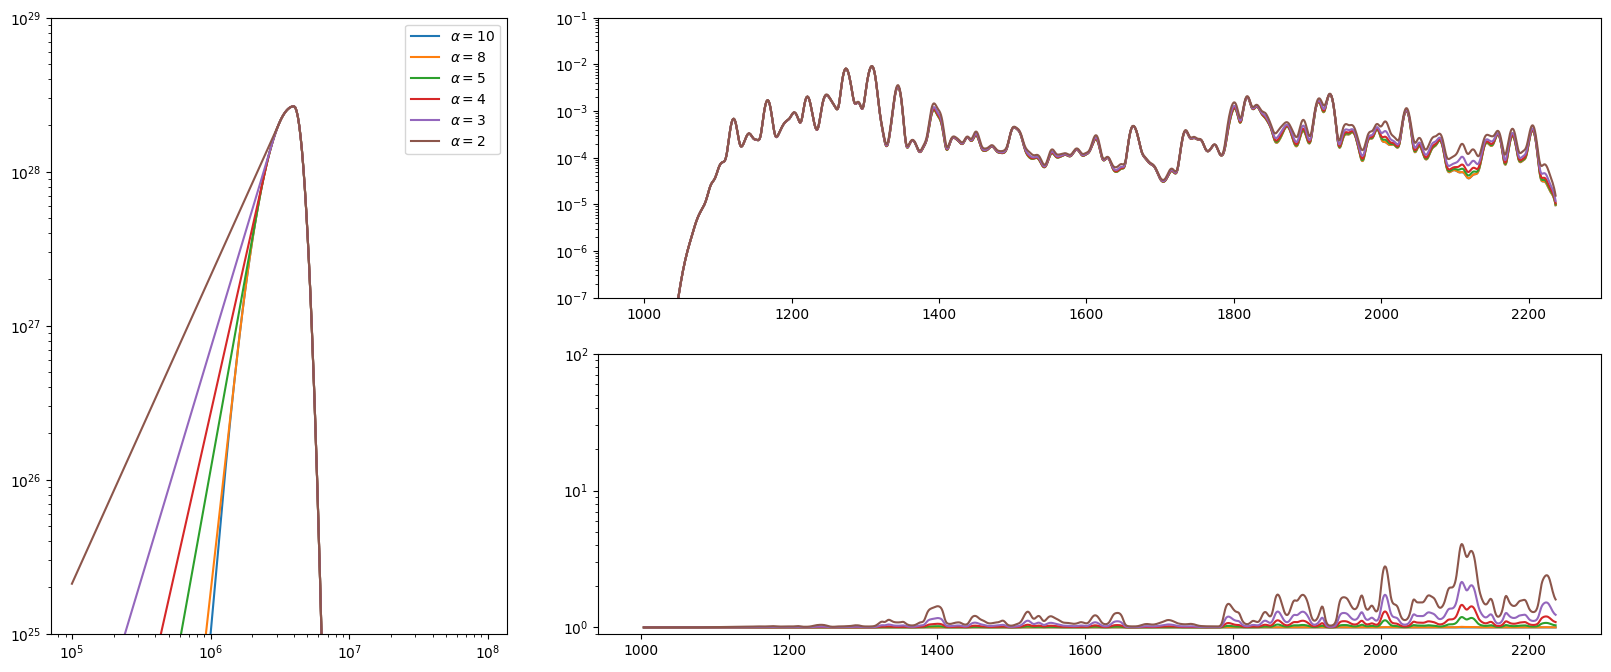

In [137]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(2, 3,)
ax1 = fig.add_subplot(gs[:,0])
ax2 = fig.add_subplot(gs[0,1:])
ax3 = fig.add_subplot(gs[1,1:])
flux0 = compute_total_flux(
    dem_table_to_ndcube(guennou_dem(temperature, 4*u.MK, EM_total, 10, 0.05), temperature),
    spec_table,
    chan_1,
    chan_3,
    pix_x_1,
    pix_x_3
)
flux0 = degrade_spectra(flux0, blur, chan_1)
for alpha in [10, 8, 5, 4, 3, 2]:
    dem = guennou_dem(temperature, 4*u.MK, EM_total, alpha, 0.05)
    ax1.plot(temperature, dem, label=f'$\\alpha={alpha}$')
    flux = compute_total_flux(
        dem_table_to_ndcube(dem, temperature),
        spec_table,
        chan_1,
        chan_3,
        pix_x_1,
        pix_x_3
    )
    flux = degrade_spectra(flux, blur, chan_1)
    ax2.plot(pix_x_1, flux.data)
    ax3.plot(pix_x_1, flux.data/flux0.data)
ax2.set_yscale('log')
ax2.set_ylim(1e-7, 1e-1)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim(1e25, 1e29)
ax3.set_ylim(9e-1,1e2)
ax3.set_yscale('log')
ax1.legend()

## Intensity Ratios

Decide which ranges to iterate over for each quantity:

- $1<T_P<10$ MK in steps of 1 MK
- $2<a<10$ in steps of 1
- $0.05<\sigma<0.5$ in steps of 0.05

In [26]:
peak_temperatures = 10**np.arange(6.0,7.6,.1) * u.K
cool_slopes = np.arange(2,11,1)
hot_sigmas = np.arange(0.05, 0.55, 0.05)

In [27]:
flux_cube = np.zeros(chan.wavelength.shape + peak_temperatures.shape + cool_slopes.shape + hot_sigmas.shape)
dem_cube = np.zeros(temperature.shape + flux_cube.shape[1:]) * u.Unit('cm-5')

In [28]:
for i, TP in enumerate(peak_temperatures):
    for j, a in enumerate(cool_slopes):
        for k, sigma in enumerate(hot_sigmas):
            #print(TP, a, sigma)
            dem = guennou_dem(temperature, TP, 1e27*u.cm**(-5), a, sigma)
            dem_cube[:, i, j, k] = dem
            intensity = InstrumentDEM.calculate_intensity(
                dem_table_to_ndcube(dem, temperature),
                spec_tables['sun_coronal_1992_feldman_ext_all'],
                {},
            )
            flux = convolve_with_response(intensity, chan, electrons=False, include_gain=False)
            flux_cube[:, i, j, k] = flux.data

In [87]:
flux_cube_oxygen = np.zeros(chan.wavelength.shape + peak_temperatures.shape + cool_slopes.shape + hot_sigmas.shape)
for i, TP in enumerate(peak_temperatures):
    for j, a in enumerate(cool_slopes):
        for k, sigma in enumerate(hot_sigmas):
            intensity = InstrumentDEM.calculate_intensity(
                dem_table_to_ndcube(dem_cube[:, i, j, k], temperature),
                spec_tables['unity_o']*get_abundance('O', 'sun_coronal_1992_feldman_ext'),
                {},
            )
            flux = convolve_with_response(intensity, chan, electrons=False, include_gain=False)
            flux_cube_oxygen[:, i, j, k] = flux.data

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [88]:
flux_cube_iron = np.zeros(chan.wavelength.shape + peak_temperatures.shape + cool_slopes.shape + hot_sigmas.shape)
for i, TP in enumerate(peak_temperatures):
    for j, a in enumerate(cool_slopes):
        for k, sigma in enumerate(hot_sigmas):
            intensity = InstrumentDEM.calculate_intensity(
                dem_table_to_ndcube(dem_cube[:, i, j, k], temperature),
                spec_tables['unity_fe']*get_abundance('Fe', 'sun_coronal_1992_feldman_ext'),
                {},
            )
            flux = convolve_with_response(intensity, chan, electrons=False, include_gain=False)
            flux_cube_iron[:, i, j, k] = flux.data

In [29]:
flux_cube_wcs = (
    QuantityTableCoordinate(u.Quantity(hot_sigmas), names='sigma') &
    QuantityTableCoordinate(u.Quantity(cool_slopes), names='a') &
    QuantityTableCoordinate(peak_temperatures, names='peak temperature', physical_types='phys.temperature') &
    QuantityTableCoordinate(chan.wavelength, names='wavelength', physical_types='em.wavelength')
).wcs
flux_ndcube = ndcube.NDCube(flux_cube, wcs=flux_cube_wcs, unit=flux.unit)

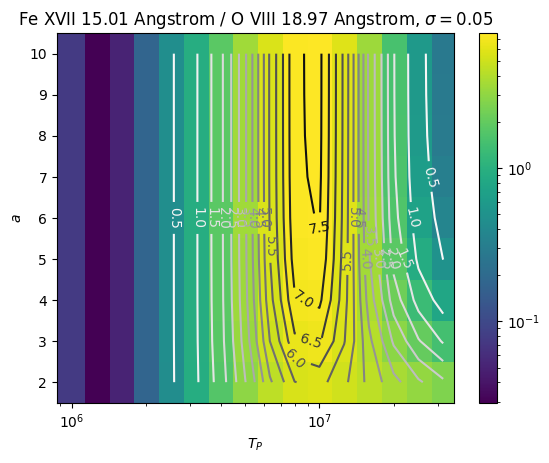

In [138]:
line_index_num = 1
line_index_denom = 7
sigma_index = 0
line_ratio = get_line_ratio(flux_cube,
                            chan.wavelength,
                            line_ids[line_index_num][1],
                            line_ids[line_index_denom][1],)
amesh,tpmesh = np.meshgrid(cool_slopes,peak_temperatures.to_value('K'))
norm = matplotlib.colors.LogNorm()
#norm = matplotlib.colors.Normalize()
plt.pcolormesh(tpmesh,
               amesh,
               line_ratio[...,sigma_index],
               norm=norm)
plt.colorbar()
contours = plt.contour(tpmesh,
                       amesh,
                       line_ratio[...,sigma_index],
                       15,
                       cmap='Greys',
                      )#norm=norm)
plt.clabel(contours, levels=contours.levels,)
plt.xlabel('$T_P$')
plt.ylabel('$a$')
plt.title(f'{line_ids[line_index_num][0]} {line_ids[line_index_num][1]} / {line_ids[line_index_denom][0]} {line_ids[line_index_denom][1]}, $\sigma={hot_sigmas[sigma_index]:.2f}$')
#plt.colorbar()
plt.xscale('log')

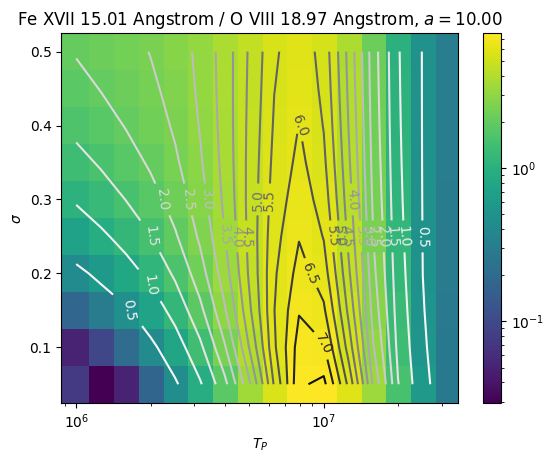

In [139]:
line_index_num = 1
line_index_denom = 7
a_index = 8
line_ratio = get_line_ratio(flux_cube,
                            chan.wavelength,
                            line_ids[line_index_num][1],
                            line_ids[line_index_denom][1],)
sigmesh,tpmesh = np.meshgrid(hot_sigmas, peak_temperatures.to_value('K'))
norm = matplotlib.colors.LogNorm()
plt.pcolormesh(tpmesh,sigmesh,line_ratio[:,a_index,:],
               norm=norm)
plt.colorbar()
contours = plt.contour(tpmesh,
                       sigmesh,
                       line_ratio[:,a_index,:],
                       15,
                       cmap='Greys',
                      )#norm=norm)
plt.clabel(contours, levels=contours.levels,)
plt.xlabel('$T_P$')
plt.ylabel('$\sigma$')
plt.title(f'{line_ids[line_index_num][0]} {line_ids[line_index_num][1]} / {line_ids[line_index_denom][0]} {line_ids[line_index_denom][1]}, $a={cool_slopes[a_index]:.2f}$')
#plt.colorbar()
plt.xscale('log')

Text(0.5, 1.0, 'O VIII 18.97 Angstrom / O VII 21.81 Angstrom, $T_P=10.00 MK$')

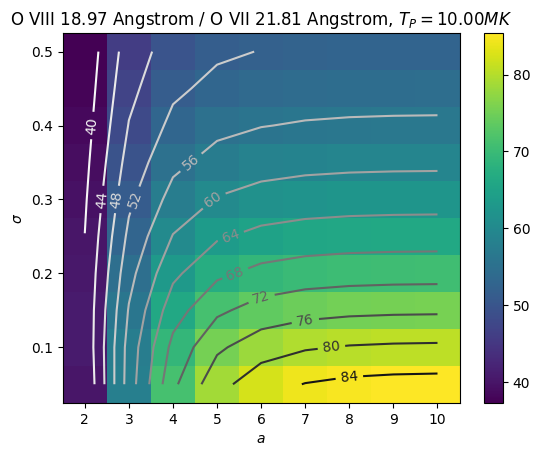

In [176]:
line_index_num = 7
line_index_denom = 5
Tp_index = 10
line_ratio = get_line_ratio(flux_cube,
                            chan.wavelength,
                            line_ids[line_index_num][1],
                            line_ids[line_index_denom][1],)
sigmesh,amesh = np.meshgrid(hot_sigmas, cool_slopes)
#norm = matplotlib.colors.LogNorm()
norm = matplotlib.colors.Normalize()
plt.pcolormesh(amesh,sigmesh,line_ratio[Tp_index,...],
               norm=norm)
plt.colorbar()
contours = plt.contour(amesh,
                       sigmesh,
                       line_ratio[Tp_index,...],
                       15,
                       cmap='Greys',
                      )#norm=norm)
plt.clabel(contours, levels=contours.levels,)
plt.xlabel('$a$')
plt.ylabel('$\sigma$')
plt.title(
    f'{line_ids[line_index_num][0]} {line_ids[line_index_num][1]} / {line_ids[line_index_denom][0]} {line_ids[line_index_denom][1]}, $T_P={peak_temperatures[Tp_index].to("MK"):.2f}$')
#plt.colorbar()

Text(0.5, 1.0, 'O VIII 18.97 Angstrom / O VII 21.81 Angstrom, $T_P=10.00 MK$')

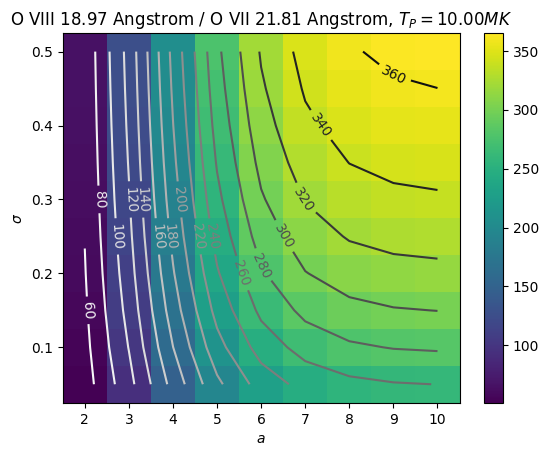

In [156]:
line_index_num = 7
line_index_denom = 5
Tp_index = 10
line_ratio = get_line_ratio(flux_cube_oxygen,
                            chan.wavelength,
                            line_ids[line_index_num][1],
                            line_ids[line_index_denom][1],)
sigmesh,amesh = np.meshgrid(hot_sigmas, cool_slopes)
#norm = matplotlib.colors.LogNorm()
norm = matplotlib.colors.Normalize()
plt.pcolormesh(amesh,sigmesh,line_ratio[Tp_index,...],
               norm=norm)
plt.colorbar()
contours = plt.contour(amesh,
                       sigmesh,
                       line_ratio[Tp_index,...],
                       15,
                       cmap='Greys',
                      )#norm=norm)
plt.clabel(contours, levels=contours.levels,)
plt.xlabel('$a$')
plt.ylabel('$\sigma$')
plt.title(
    f'{line_ids[line_index_num][0]} {line_ids[line_index_num][1]} / {line_ids[line_index_denom][0]} {line_ids[line_index_denom][1]}, $T_P={peak_temperatures[Tp_index].to("MK"):.2f}$')
#plt.colorbar()

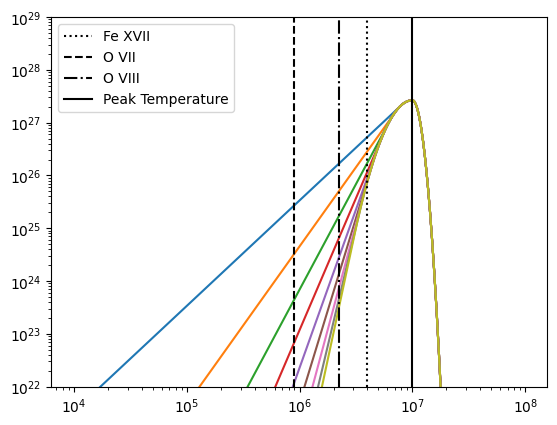

In [55]:
for i,a in enumerate(cool_slopes):
    plt.plot(temperature, dem_cube[:,Tp_index,i,0])
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e22,1e29)
#plt.ylim(.1,1e3)
plt.axvline(x=fe_17.formation_temperature.to_value('K'), ls=':', color='k', label=fe_17.ion_name_roman)
plt.axvline(x=o_7.formation_temperature.to_value('K'), ls='--', color='k', label=o_7.ion_name_roman)
plt.axvline(x=o_8.formation_temperature.to_value('K'), ls='-.', color='k', label=o_8.ion_name_roman)
plt.axvline(x=peak_temperatures[Tp_index].to_value('K'), ls='-', color='k', label='Peak Temperature')
plt.legend()

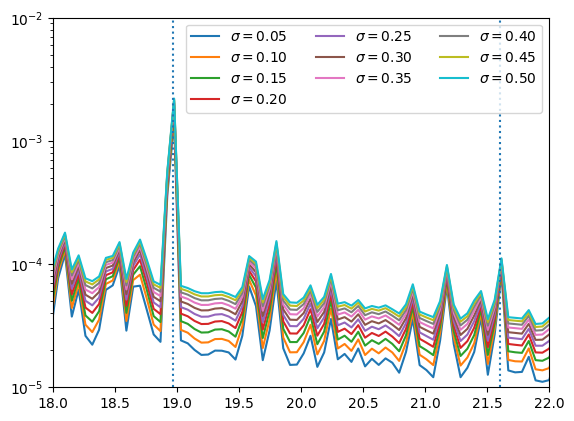

In [57]:
for i,sig in enumerate(hot_sigmas):
    plt.plot(chan.wavelength, flux_cube[:,Tp_index,4,i], label=f'$\sigma={sig:.2f}$')
plt.axvline(x=line_ids[4][1].to_value('Angstrom'),ls=':')
plt.axvline(x=line_ids[7][1].to_value('Angstrom'),ls=':')
plt.xlim(18,22)
plt.yscale('log')
plt.ylim(1e-5,1e-2)
plt.legend(ncol=3)

(327.27272727272725, 400.0)

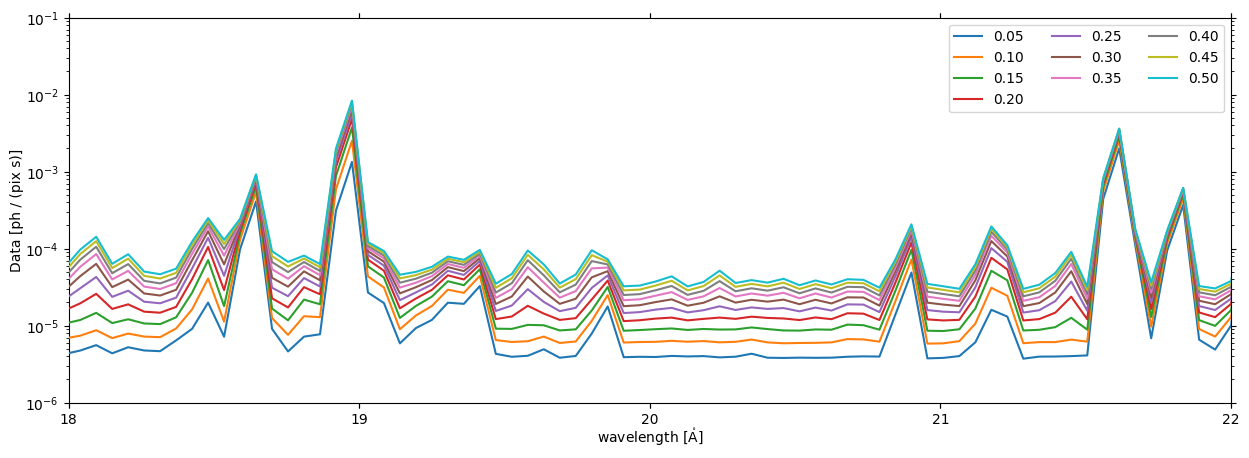

In [125]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(projection=flux_ndcube[:,0,0,0].wcs)
for i,hs in enumerate(hot_sigmas):
    flux_ndcube[:,Tp_index, 0,i].plot(axes=ax, label=f'{hs:.2f}')
ax.legend(ncol=3)
ax.set_yscale('log')
ax.set_ylim(1e-6,1e-1)
ax.set_xlim(ax.wcs.world_to_pixel_values([18,22]*u.angstrom))

(18.0, 22.0)

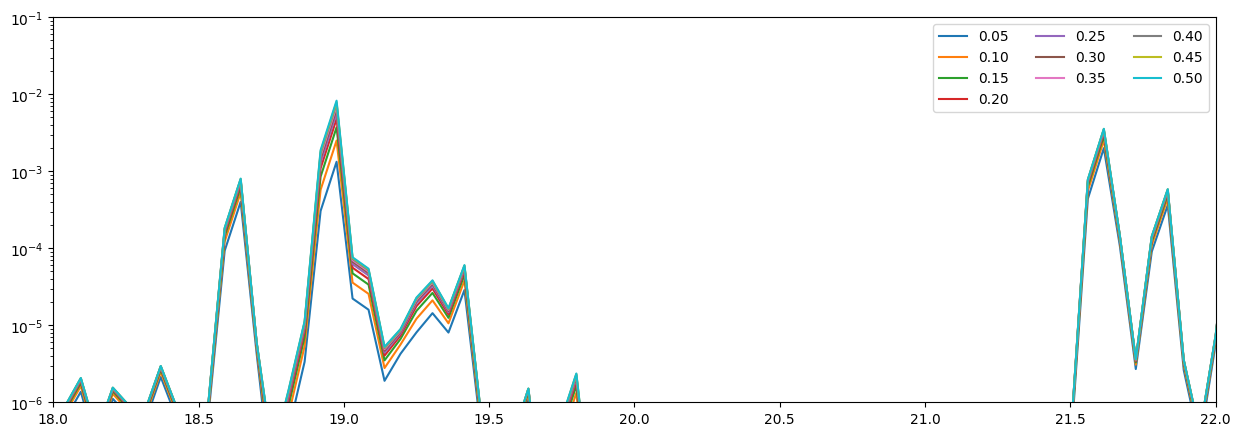

In [127]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot()
for i,hs in enumerate(hot_sigmas):
    ax.plot(chan.wavelength, flux_cube_oxygen[:, Tp_index, 0, i], label=f'{hs:.2f}')
ax.legend(ncol=3)
ax.set_yscale('log')
ax.set_ylim(1e-6,1e-1)
ax.set_xlim(18,22)

(18.0, 22.0)

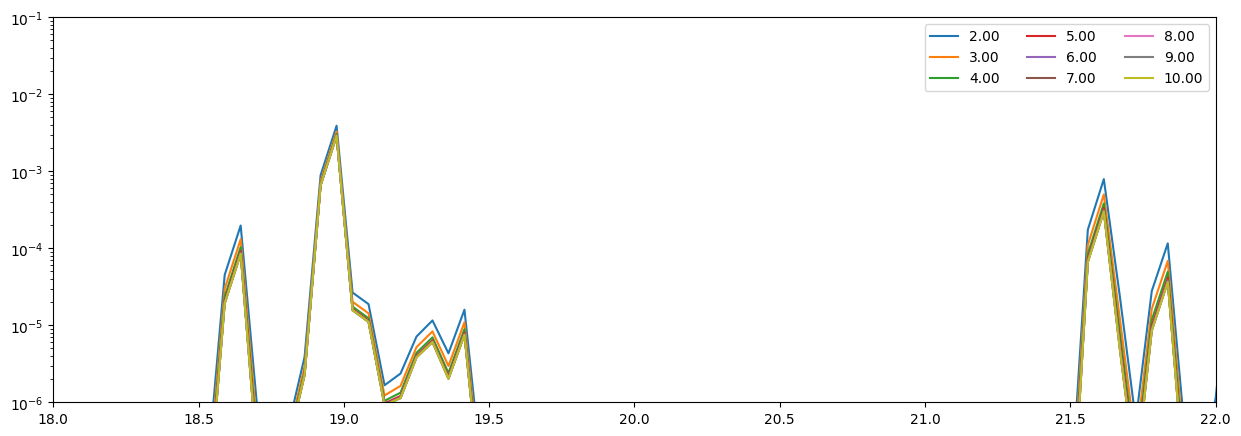

In [134]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot()
for i,a in enumerate(cool_slopes):
    ax.plot(chan.wavelength, flux_cube_oxygen[:, 8, i, 0], label=f'{a:.2f}')
ax.legend(ncol=3)
ax.set_yscale('log')
ax.set_ylim(1e-6,1e-1)
ax.set_xlim(18,22)

## Comparisons with Relevant Contribution Functions

In [23]:
fe_17 = fiasco.Ion('Fe XVII', temperature)
o_7 = fiasco.Ion('O VII', temperature)
o_8 =  o_7.next_ion()

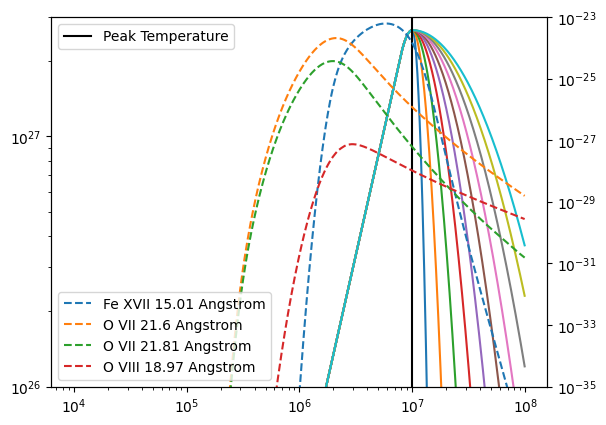

In [159]:
fig = plt.figure()
ax = fig.add_subplot()
for i,hs in enumerate(hot_sigmas):
    ax.plot(temperature, dem_cube[:,Tp_index,0,i])#/dem_cube[:,Tp_index,-1,0])
ax2 = ax.twinx()
for li in [line_ids[1], line_ids[4], line_ids[5], line_ids[7]]:
    ax2.plot(temperature, get_goft(fiasco.Ion(li[0], temperature), li[1]),
             label=f'{li[0]} {li[1]}', ls='--')
ax.set_xscale('log')
ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_ylim(1e26,3e27)
ax2.set_ylim(1e-35, 1e-23)
#plt.ylim(.1,1e3)
#plt.axvline(x=fe_17.formation_temperature.to_value('K'), ls=':', color='k', label=fe_17.ion_name_roman)
#plt.axvline(x=o_7.formation_temperature.to_value('K'), ls='--', color='k', label=o_7.ion_name_roman)
#plt.axvline(x=o_8.formation_temperature.to_value('K'), ls='-.', color='k', label=o_8.ion_name_roman)
ax.axvline(x=peak_temperatures[Tp_index].to_value('K'), ls='-', color='k', label='Peak Temperature')
ax.legend(loc=2)
ax2.legend(loc=3)

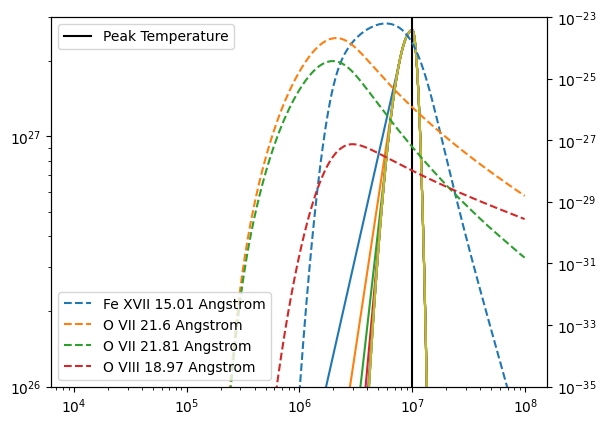

In [160]:
fig = plt.figure()
ax = fig.add_subplot()
for i,a in enumerate(cool_slopes):
    ax.plot(temperature, dem_cube[:,Tp_index,i,0])#/dem_cube[:,Tp_index,-1,0])
ax2 = ax.twinx()
for li in [line_ids[1], line_ids[4], line_ids[5], line_ids[7]]:
    ax2.plot(temperature, get_goft(fiasco.Ion(li[0], temperature), li[1]),
             label=f'{li[0]} {li[1]}', ls='--')
ax.set_xscale('log')
ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_ylim(1e26,3e27)
ax2.set_ylim(1e-35, 1e-23)
#plt.ylim(.1,1e3)
#plt.axvline(x=fe_17.formation_temperature.to_value('K'), ls=':', color='k', label=fe_17.ion_name_roman)
#plt.axvline(x=o_7.formation_temperature.to_value('K'), ls='--', color='k', label=o_7.ion_name_roman)
#plt.axvline(x=o_8.formation_temperature.to_value('K'), ls='-.', color='k', label=o_8.ion_name_roman)
ax.axvline(x=peak_temperatures[Tp_index].to_value('K'), ls='-', color='k', label='Peak Temperature')
ax.legend(loc=2)
ax2.legend(loc=3)

(1e-35, 1e-23)

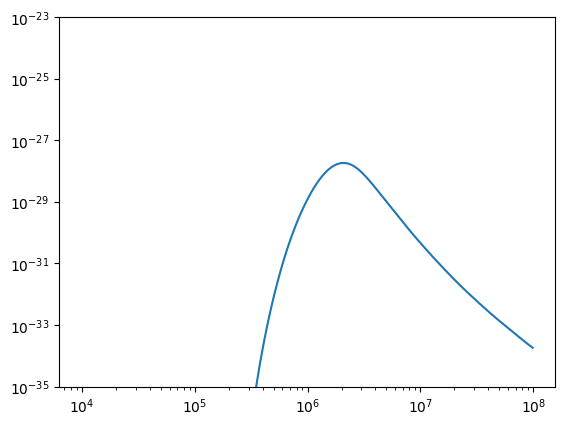

In [167]:
plt.plot(temperature, get_goft(fiasco.Ion('O VII', temperature), 18.9723*u.AA), label='18.9723')
plt.plot(temperature, get_goft(fiasco.Ion('O VII', temperature), 18.9726*u.AA), label='18.9726')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-35, 1e-23)

In [203]:
silicon = fiasco.Element('Si', np.logspace(4,9,10000)*u.K)
oxygen = fiasco.Element('O', silicon.temperature)

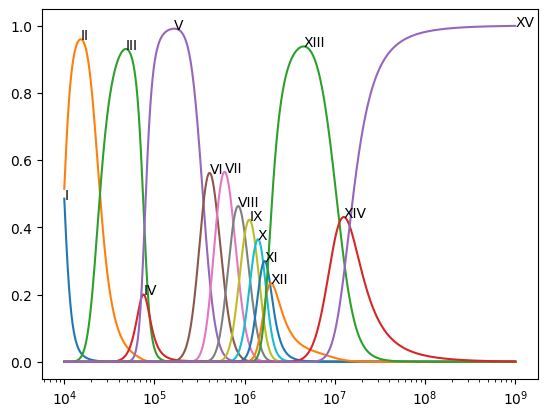

In [209]:
for ion in silicon:
    ioneq = silicon.equilibrium_ionization[:, ion.charge_state]
    plt.plot(silicon.temperature, ioneq)
    plt.annotate(ion.ionization_stage_roman, (ion.temperature[ioneq.argmax()].value, ioneq.max().value))
plt.xscale('log')

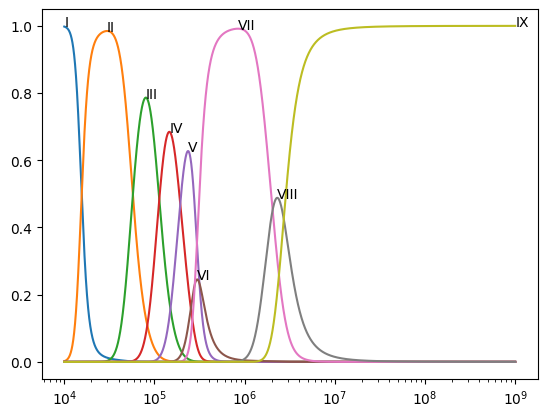

In [210]:
for ion in oxygen:
    ioneq = oxygen.equilibrium_ionization[:, ion.charge_state]
    plt.plot(oxygen.temperature, ioneq)
    plt.annotate(ion.ionization_stage_roman, (ion.temperature[ioneq.argmax()].value, ioneq.max().value))
plt.xscale('log')